# Supplement 2.1. Survival Analysis Methods for Pulses

Here, we analyze the duration of pulses using several different methods of multivariate survival analysis.<br>

Employed methods are outlined below. To execute a model, first run the code cell in **2.1.1. Import and Screen Data**. Then, for a model of interest, run code cells in sequence.<br>

**2.1.1. Import and Screen Data.**<br>

**2.1.2. Cox Proportional Harazards Model.**<br>

**2.1.3. Penalized Cox Models.**<br>
*2.1.3.1. Ridge.*<br>
*2.1.3.2. Lasso.*<br>
*2.1.3.3. Elastic Net.*<br>

**2.1.4. Random Survival Forest Model.**<br>

**2.1.5. Gradient Boosted Models.**<br>
*2.1.5.1. Gradient Boosting.*<br>
*2.1.5.2. Component-wise Gradient Boosting.*<br>

**2.1.6. XGBoost Model.**<br>

**2.1.7. Neural network (CoxTime) Model.**<br>

## 2.1.1. Import and Screen Data.
Here we import libraries and data, and we remove correlated features.

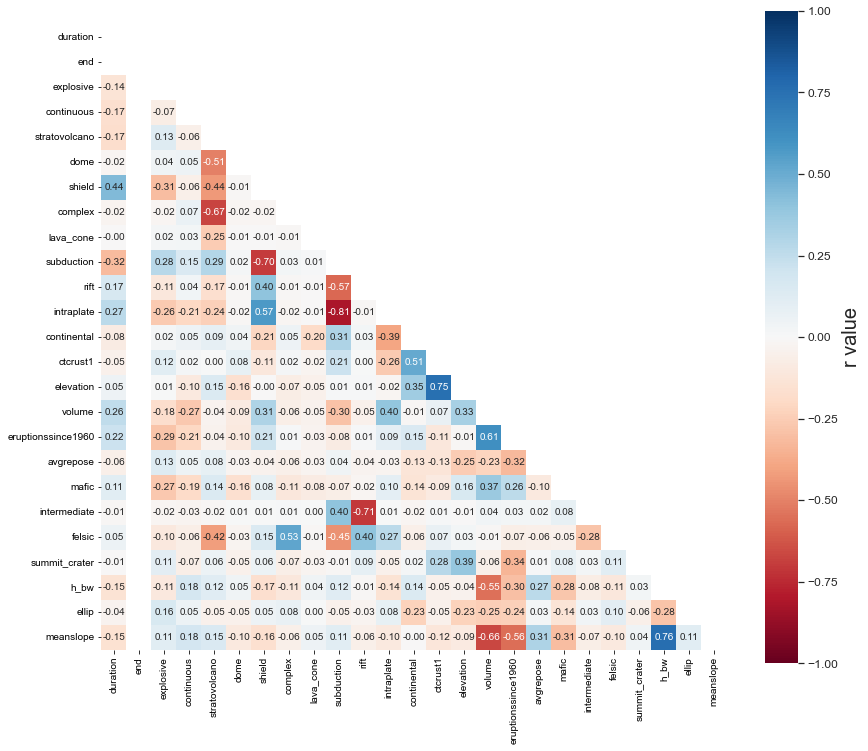

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Import data
df = pd.read_csv( 'input/pulse_durations.csv' )

# Remove empty features
df = df.loc[:, (df != 0).any(axis=0)]

# Convert duration from days to seconds
df.duration *= 24*60*60

# Plot correlation matrix
CM = df.corr()
mask = np.triu( np.ones_like( CM, dtype=bool ) )
fig, ax = plt.subplots( figsize=(14, 12) )
sns.set(font_scale=1.1)
ax = sns.heatmap( CM, mask=mask, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt='.2f', square=True, cbar_kws={'label': 'r value'},annot_kws={"size": 10} )
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.set_facecolor('w')
plt.show()

In [2]:
# Remove highly correlated (r >= 0.7) features
remove = [ 'rift', 'intraplate', 'ctcrust1', 'meanslope', 'shield']
df.drop( columns=remove, inplace=True )

## 2.1.2. Cox Proportional Hazards Model.
The Cox Proportional Hazards Model is probably the most widely used model in survival analysis today. The model was proposed by Cox (1972). The model is described as semi-parametric. A predicted hazard is calculated by finding the product of a baseline hazard function, which is typically nonparametric but could be described by a function, and a exponential function that is the linear combination of a set of coefficients (or predictors).

Cox, D.R., 1972. Regression models and life‐tables. Journal of the Royal Statistical Society: Series B (Methodological), 34(2), pp.187-202.

<lifelines.CoxPHFitter: fitted with 265 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'end'
      baseline estimation = breslow
   number of observations = 265
number of events observed = 265
   partial log-likelihood = -1160.72
         time fit was run = 2022-01-10 13:36:58 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
explosive            0.74       2.10       0.25             0.25             1.23                 1.28                 3.43
continuous           1.05       2.85       0.20             0.66             1.44                 1.93                 4.22
stratovolcano        2.65      14.22       1.09             0.52             4.79                 1.69               119.79
dome                 3.59      36.05       1.23             1.18             5.99                 3.24               400.95
complex              3.71      40.81       1.26             1.24             6.18                 3.45               482.01
lava_cone            1.93       6.89       1.54            -1.08             4.94                 0.34               139.64
subduction          -1.62       0.20       0.97            -3.52             0.27                 0.03                 1.31
continental          1.06       2.89       0.31             0.45             1.67                 1.57                 5.31
elevation           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
volume               0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
eruptionssince1960  -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
avgrepose            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mafic               -0.16       0.86       0.16            -0.47             0.16                 0.62                 1.17
intermediate         2.76      15.73       1.31             0.19             5.33                 1.20               205.64
felsic              -0.79       0.45       0.44            -1.66             0.08                 0.19                 1.08
summit_crater        0.39       1.47       0.23            -0.06             0.83                 0.94                 2.30
h_bw                 6.28     534.49       2.35             1.68            10.88                 5.37             53224.55
ellip                1.22       3.39       0.42             0.41             2.04                 1.50                 7.66

                       z      p   -log2(p)
covariate                                 
explosive           2.96 <0.005       8.34
continuous          5.23 <0.005      22.52
stratovolcano       2.44   0.01       6.10
dome                2.92 <0.005       8.14
complex             2.94 <0.005       8.27
lava_cone           1.26   0.21       2.26
subduction         -1.68   0.09       3.44
continental         3.42 <0.005      10.63
elevation          -3.75 <0.005      12.48
volume              1.98   0.05       4.40
eruptionssince1960 -0.86   0.39       1.37
avgrepose           0.57   0.57       0.81
mafic              -0.97   0.33       1.58
intermediate        2.10   0.04       4.81
felsic             -1.78   0.07       3.74
summit_crater       1.70   0.09       3.50
h_bw                2.68   0.01       7.07
ellip               2.93 <0.005       8.22
---
Concordance = 0.71
Partial AIC = 2357.45
log-likelihood ratio test = 113.23 on 18 df
-log2(p) of ll-ratio test = 50.18

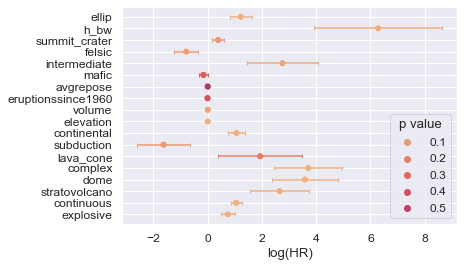

In [34]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sksurv.linear_model import CoxPHSurvivalAnalysis as CPHSA
from sksurv.metrics import integrated_brier_score
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from lifelines import CoxPHFitter as CPHF
import matplotlib as mpl

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Feature selection
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Fit data
cph = CPHF()
cph.fit(df, 'duration',event_col='end')

# Print summary of results
cph.print_summary()

# Store results
summary = cph.summary
summary['i'] = range(len(summary.iloc[:,0]))

# Plot results
ax = sns.scatterplot( data=summary, x='coef', y='i', marker='o', s=50, hue='p', palette='flare', legend='brief', hue_norm=(0,1) )

norm = mpl.colors.Normalize( vmin=0, vmax=1, clip=True )
mapper = mpl.cm.ScalarMappable( norm=norm, cmap='flare' )
time_color = np.array( [ (mapper.to_rgba(i)) for i in summary.p ] )

for x, y, err, z in zip( summary.coef, summary.i, summary['se(coef)'], time_color ):
    ax.errorbar( x, y, xerr=err, fmt ='none', capsize=2, color=z )

ax.set_yticks(summary.i)
ax.set_yticklabels(summary.index)

ax.set_ylabel('')
ax.set_xlabel('log(HR)')

ax.legend( title = 'p value' )

plt.show()

In [41]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare data
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Remove features with high p values (>=0.03)
remove = [ 'lava_cone', 'subduction', 'volume', 'eruptionssince1960', 'avgrepose', 'mafic', 'intermediate', 'felsic', 'summit_crater' ]
DF = df.copy()
DF.drop( columns=remove, inplace=True )

# Prepare data for cross validation
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()
Xt = Xt.values

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 1

kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

model = CPHSA()
results = cross_val_score(model, Xt, y, cv=kf)

# Print results
print( 'Average concordance index for ({0} repeats of 5-fold cross validation): {1}'.format( 5, round(results.mean(),4) ) )
print( 'Standard deviation: {}'.format( round(results.std(ddof=1),4) ) )

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, integrated brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

random_states = [20,21,22,23,24]
results = []
model = CPHSA()

for seed in random_states:
    kf = KFold(n_splits=5,shuffle=True,random_state=seed)
    kf.get_n_splits(y)
    for train_index, test_index in kf.split(y):
        
        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        #filter test dataset so we only consider event times within the range given by the training datasets
        mask = (y_test.field(1) >= min(y_train.field(1))) & (y_test.field(1) <= max(y_train.field(1)))
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        survs = model.predict_survival_function(X_test)
        times = np.linspace( np.percentile([time[1] for time in y_test], 25), np.percentile([time[1] for time in y_test], 75), 10 )
        preds = np.asarray( [ [sf(t) for t in times] for sf in survs ] )
        score = integrated_brier_score(y_train, y_test, preds, times)
        
        results.append( score )

# Print results
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results,ddof=1),4) ) )

Average concordance index for (5 repeats of 5-fold cross validation): 0.676
Standard deviation: 0.0354
Average Brier score for (5 repeats of 5-fold cross validation): 0.1785
Standard deviation: 0.0105


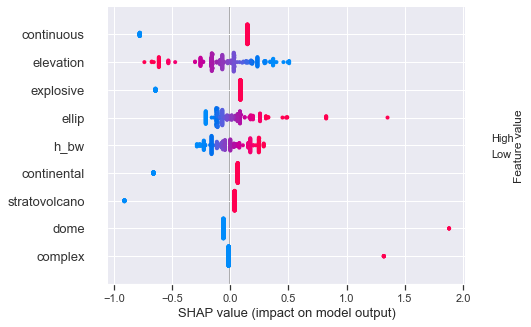

In [42]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

model = CPHSA()
model.fit(Xt,y)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

explainer = shap.Explainer(model.predict, Xt, feature_names=feature_names)
shaps = explainer(Xt)
shap.summary_plot(shaps, Xt)

## 2.1.3. Penalized Cox Models.
The penalized Cox model attempts to maximize the predictive value of the Cox regression model by subtracting a penalty function of the regression coefficients from the partial log-likelihood. This class of methods is typically applied when the number of covariates is greater than the sample size. The approach can help to alleviate problems associated with overfitting and high collinearity of covariates. There are three main approaches to penalized Cox regression: L2-penalized regression (ridge), L1-penalized regression (lasso), and elasic net (combines L2 and L1).

*2.1.3.1. Ridge.*<br>
The L2-penalized regression method is used in the ridge regression approach (Hoerl and Kennard, 1970). This method adds a penalaty term that shrinks all coefficients to zero. Therefore, all coeffients are conserved when using this approach.

Hoerl, A.E. and Kennard, R.W., 1970. Ridge regression: Biased estimation for nonorthogonal problems. Technometrics, 12(1), pp.55-67.

*2.1.3.2. Lasso.*<br>
Lasso regression uses the L1-penalized regression method, which was proposed by Tibshirani (1996). This method finds a subset of covariates that are most predictive and ignores the others.

Tibshirani, R., 1996. Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58(1), pp.267-288.

*2.1.3.3. Elastic Net.*<br>
The elastic net method uses a weighted combination of the L1 and L2 penalties (Zou and Hastie, 2005). The L1 penalty has the strength of selecting the most predictive subset of covariates, and the L2 penalty regularizes the coefficients.

Zou, H. and Hastie, T., 2005. Regularization and variable selection via the elastic net. Journal of the royal statistical society: series B (statistical methodology), 67(2), pp.301-320.

### 2.1.3.1. Ridge.

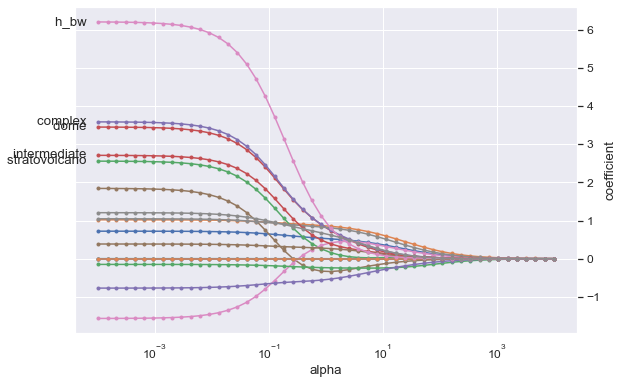

In [43]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sksurv.linear_model import CoxPHSurvivalAnalysis as CPHSA
from sksurv.metrics import integrated_brier_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, GridSearchCV

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Define a function used for plotting
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare variables
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

DF = df.copy()
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Visualize the ridge penalty effect on coefficients
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CPHSA()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

plot_coefficients(coefficients, n_highlight=5)

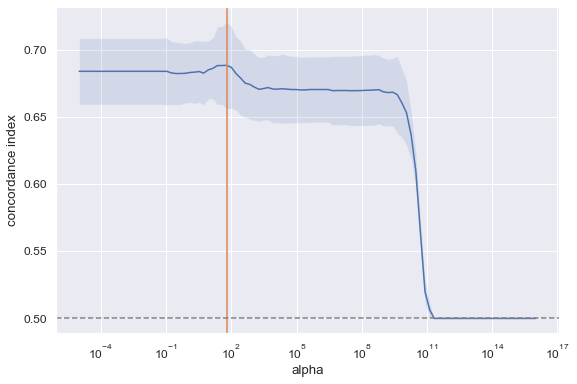

In [44]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Optimize model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
seed = 1

alphas = 10. ** np.linspace(-5, 16, 100)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
gcv = GridSearchCV(
                    make_pipeline(StandardScaler(), CPHSA()),
                    param_grid={"coxphsurvivalanalysis__alpha": [a for a in alphas]},
                    cv=cv,
                    error_score=0.5,
                    n_jobs=-1
                  ).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

mean = cv_results.mean_test_score.values
std = cv_results.std_test_score.values

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxphsurvivalanalysis__alpha"], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [45]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 10

kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

model = CPHSA(alpha=gcv.best_params_["coxphsurvivalanalysis__alpha"])
results = cross_val_score(model, Xt, y, cv=kf)

# Print results
print( 'Average concordance index for ({0} repeats of 5-fold cross validation): {1}'.format( 5, round(results.mean(),4) ) )
print( 'Standard deviation: {}'.format( round(results.std(ddof=1),4) ) )

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, integrated brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

random_states = [11,12,13,14,15]
results = []
model = CPHSA(alpha=gcv.best_params_["coxphsurvivalanalysis__alpha"])
Xt = Xt.values

for seed in random_states:
    kf = KFold(n_splits=5,shuffle=True,random_state=seed)
    kf.get_n_splits(y)
    for train_index, test_index in kf.split(y):
        
        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        #filter test dataset so we only consider event times within the range given by the training datasets
        mask = (y_test.field(1) >= min(y_train.field(1))) & (y_test.field(1) <= max(y_train.field(1)))
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        survs = model.predict_survival_function(X_test)
        times = np.linspace( np.percentile([time[1] for time in y_test], 25), np.percentile([time[1] for time in y_test], 75), 10 )
        preds = np.asarray( [ [sf(t) for t in times] for sf in survs ] )
        score = integrated_brier_score(y_train, y_test, preds, times)
        
        results.append( score )

# Print results
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results,ddof=1),4) ) )

Average concordance index for (5 repeats of 5-fold cross validation): 0.6317
Standard deviation: 0.0383
Average Brier score for (5 repeats of 5-fold cross validation): 0.1926
Standard deviation: 0.0149


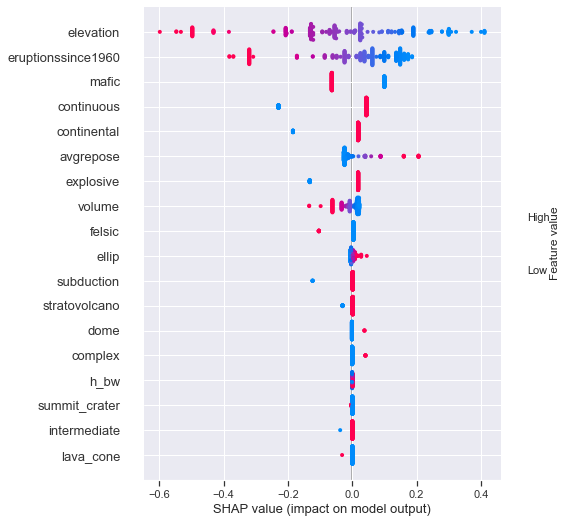

In [46]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

model = CPHSA(alpha=gcv.best_params_["coxphsurvivalanalysis__alpha"])
model.fit(Xt,y)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

explainer = shap.Explainer(model.predict, Xt, feature_names=feature_names)
shaps = explainer(Xt)
shap.summary_plot(shaps, Xt)

### 2.1.3.2. Lasso.

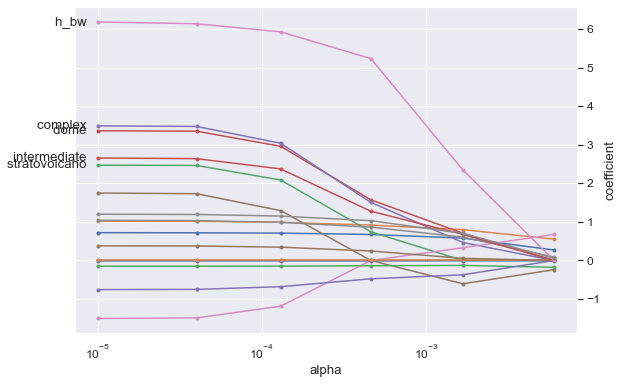

In [47]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold, cross_val_score

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Define a function used for plotting
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare variables
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

DF = df.copy()
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Visualize penalty effect on coefficients
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

alphas = 10. ** np.linspace(-5, 0, 10)
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=1, alphas=alphas, normalize=True)

cox_elastic_net.fit(Xt, y)

coefficients_elastic_net = pd.DataFrame(
                                        cox_elastic_net.coef_,
                                        index=Xt.columns,
                                        columns=np.round(cox_elastic_net.alphas_, 5)
                                       )

plot_coefficients(coefficients_elastic_net, n_highlight=5)

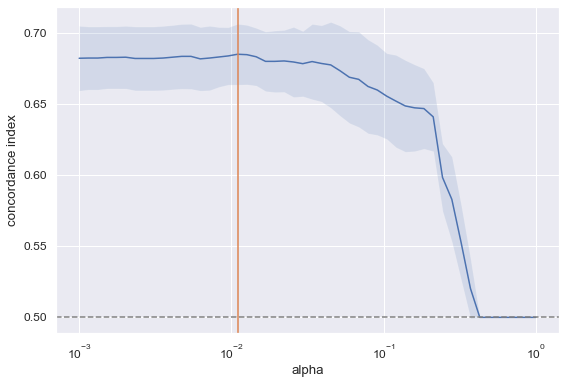

In [48]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
seed = 1

estimated_alphas = 10. ** np.linspace(-3, 0, 50)

cv = KFold(n_splits=5, shuffle=True, random_state=seed)
gcv = GridSearchCV(
                    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)),
                    param_grid={"coxnetsurvivalanalysis__alphas": [[a] for a in estimated_alphas]},
                    cv=cv,
                    error_score=0.5,
                    n_jobs=-1
                  ).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [49]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 1

kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

model = CoxnetSurvivalAnalysis(l1_ratio=1,n_alphas=1,alphas=gcv.best_params_["coxnetsurvivalanalysis__alphas"],fit_baseline_model=True)
results = cross_val_score(model, Xt, y, cv=kf)

# Print results
print( 'Average concordance index for ({0} repeats of 5-fold cross validation): {1}'.format( 5, round(results.mean(),4) ) )
print( 'Standard deviation: {}'.format( round(results.std(ddof=1),4) ) )

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, integrated brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

random_states = [11,12,13,14,15]
results = []
model = CoxnetSurvivalAnalysis(l1_ratio=1,n_alphas=1,alphas=gcv.best_params_["coxnetsurvivalanalysis__alphas"],fit_baseline_model=True)
Xt = Xt.values

for seed in random_states:
    kf = KFold(n_splits=5,shuffle=True,random_state=seed)
    kf.get_n_splits(y)
    for train_index, test_index in kf.split(y):
        
        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        #filter test dataset so we only consider event times within the range given by the training datasets
        mask = (y_test.field(1) >= min(y_train.field(1))) & (y_test.field(1) <= max(y_train.field(1)))
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        survs = model.predict_survival_function(X_test)
        times = np.linspace( np.percentile([time[1] for time in y_test], 25), np.percentile([time[1] for time in y_test], 75), 10 )
        preds = np.asarray( [ [sf(t) for t in times] for sf in survs ] )
        score = integrated_brier_score(y_train, y_test, preds, times)
        
        results.append( score )

# Print results
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results,ddof=1),4) ) )

Average concordance index for (5 repeats of 5-fold cross validation): 0.6593
Standard deviation: 0.0378
Average Brier score for (5 repeats of 5-fold cross validation): 0.1821
Standard deviation: 0.0176


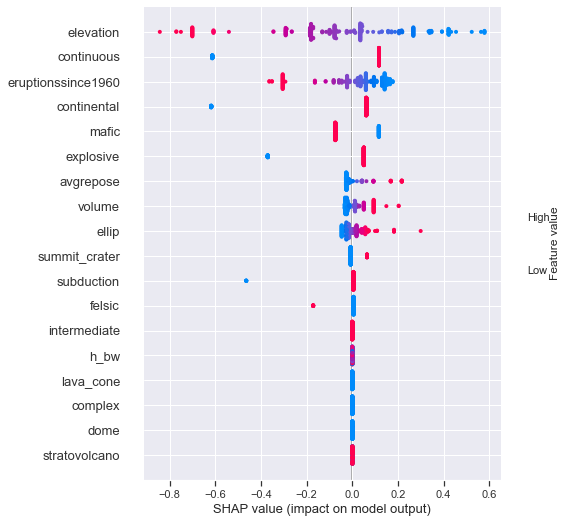

In [50]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

model = CoxnetSurvivalAnalysis(l1_ratio=1,n_alphas=1,alphas=gcv.best_params_["coxnetsurvivalanalysis__alphas"],fit_baseline_model=True)
model.fit(Xt,y)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

explainer = shap.Explainer(model.predict, Xt, feature_names=feature_names)
shaps = explainer(Xt)
shap.summary_plot(shaps, Xt)

Number of non-zero coefficients: 17


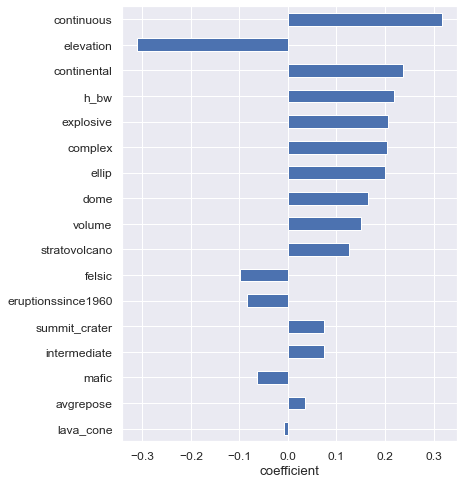

In [51]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Alternative method for evaluating features
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

best_coefs = pd.DataFrame(
                            best_model.coef_,
                            index=feature_names,
                            columns=["coefficient"]
                         )

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### 2.1.3.3. Elastic Net.

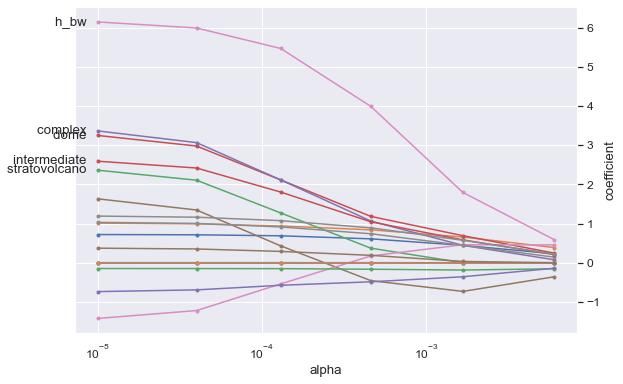

In [52]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold, cross_val_score

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Define a function used for plotting
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare variables
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

DF = df.copy()
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Visualize penalty effect on coefficients
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

alphas = 10. ** np.linspace(-5, 0, 10)
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.5, alphas=alphas, normalize=True)

cox_elastic_net.fit(Xt, y)

coefficients_elastic_net = pd.DataFrame(
                                        cox_elastic_net.coef_,
                                        index=Xt.columns,
                                        columns=np.round(cox_elastic_net.alphas_, 5)
                                       )

plot_coefficients(coefficients_elastic_net, n_highlight=5)

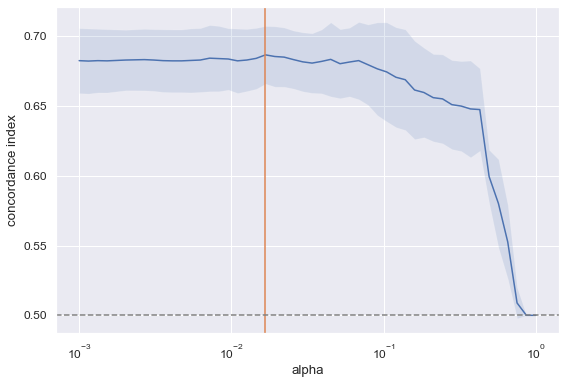

In [53]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
seed = 1

estimated_alphas = 10. ** np.linspace(-3, 0, 50)

cv = KFold(n_splits=5, shuffle=True, random_state=seed)
gcv = GridSearchCV(
                    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.5)),
                    param_grid={"coxnetsurvivalanalysis__alphas": [[a] for a in estimated_alphas]},
                    cv=cv,
                    error_score=0.5,
                    n_jobs=-1
                  ).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [54]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 1

kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

model = CoxnetSurvivalAnalysis(l1_ratio=0.5,n_alphas=1,alphas=gcv.best_params_["coxnetsurvivalanalysis__alphas"],fit_baseline_model=True)
results = cross_val_score(model, Xt, y, cv=kf)

# Print results
print( 'Average concordance index for ({0} repeats of 5-fold cross validation): {1}'.format( 5, round(results.mean(),4) ) )
print( 'Standard deviation: {}'.format( round(results.std(ddof=1),4) ) )

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, integrated brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

random_states = [11,12,13,14,15]
results = []
model = CoxnetSurvivalAnalysis(l1_ratio=1,n_alphas=1,alphas=gcv.best_params_["coxnetsurvivalanalysis__alphas"],fit_baseline_model=True)
Xt = Xt.values

for seed in random_states:
    kf = KFold(n_splits=5,shuffle=True,random_state=seed)
    kf.get_n_splits(y)
    for train_index, test_index in kf.split(y):
        
        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        #filter test dataset so we only consider event times within the range given by the training datasets
        mask = (y_test.field(1) >= min(y_train.field(1))) & (y_test.field(1) <= max(y_train.field(1)))
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        survs = model.predict_survival_function(X_test)
        times = np.linspace( np.percentile([time[1] for time in y_test], 25), np.percentile([time[1] for time in y_test], 75), 10 )
        preds = np.asarray( [ [sf(t) for t in times] for sf in survs ] )
        score = integrated_brier_score(y_train, y_test, preds, times)
        
        results.append( score )

# Print results
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results,ddof=1),4) ) )

Average concordance index for (5 repeats of 5-fold cross validation): 0.6605
Standard deviation: 0.0393
Average Brier score for (5 repeats of 5-fold cross validation): 0.1831
Standard deviation: 0.0165


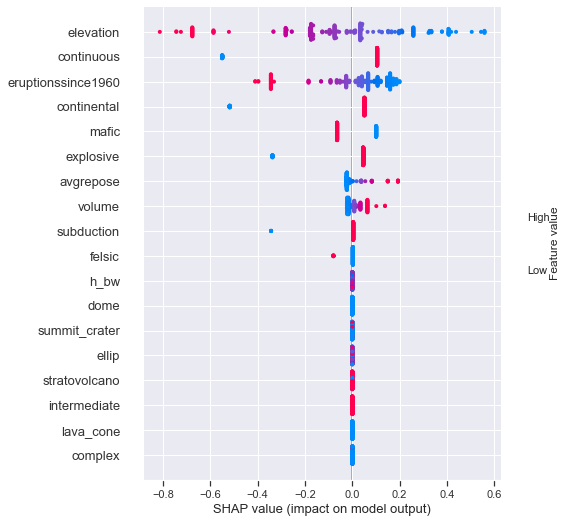

In [55]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

model = CoxnetSurvivalAnalysis(l1_ratio=1,n_alphas=1,alphas=gcv.best_params_["coxnetsurvivalanalysis__alphas"],fit_baseline_model=True)
model.fit(Xt,y)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

explainer = shap.Explainer(model.predict, Xt, feature_names=feature_names)
shaps = explainer(Xt)
shap.summary_plot(shaps, Xt)

Number of non-zero coefficients: 17


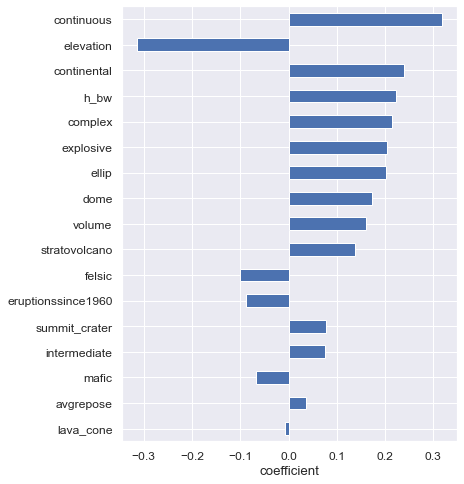

In [56]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Alternative method for evaluating features
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

best_coefs = pd.DataFrame(
                            best_model.coef_,
                            index=feature_names,
                            columns=["coefficient"]
                         )

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

## 2.1.4. Random Survival Forest Model.
WRITE DESCRIPTION.

In [57]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score
from sklearn.model_selection import KFold, GridSearchCV
from eli5.sklearn import PermutationImportance

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare data
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

DF = df.copy()
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()
Xt = Xt.values

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Initial optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 0

# Make a small grid
min_samples_split = [5,10,20]
min_samples_leaf = [2,3,4,5]
param_grid = dict( min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf )

# Grid search
grid = GridSearchCV(estimator=RandomSurvivalForest( n_estimators=1000,
                                                    max_features='sqrt',
                                                    n_jobs=-1,
                                                    random_state=1 ),
                    param_grid=param_grid,
                    cv=KFold(random_state=seed, shuffle=True),
                    verbose=False)
grid_results = grid.fit( Xt, y )

# Assess results
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
best = grid_results.best_params_

for mean, stdev, param in zip(means, stds, params):
    print( '{0} ({1}) with: {2}'.format(round(mean,3), round(stdev,3), param) )

print( 'Best: {0}, using {1}'.format(grid_results.best_score_, best) )

0.675 (0.047) with: {'min_samples_leaf': 2, 'min_samples_split': 5}
0.674 (0.047) with: {'min_samples_leaf': 2, 'min_samples_split': 10}
0.667 (0.046) with: {'min_samples_leaf': 2, 'min_samples_split': 20}
0.675 (0.045) with: {'min_samples_leaf': 3, 'min_samples_split': 5}
0.675 (0.048) with: {'min_samples_leaf': 3, 'min_samples_split': 10}
0.664 (0.043) with: {'min_samples_leaf': 3, 'min_samples_split': 20}
0.672 (0.048) with: {'min_samples_leaf': 4, 'min_samples_split': 5}
0.669 (0.044) with: {'min_samples_leaf': 4, 'min_samples_split': 10}
0.661 (0.043) with: {'min_samples_leaf': 4, 'min_samples_split': 20}
0.662 (0.044) with: {'min_samples_leaf': 5, 'min_samples_split': 5}
0.662 (0.044) with: {'min_samples_leaf': 5, 'min_samples_split': 10}
0.662 (0.041) with: {'min_samples_leaf': 5, 'min_samples_split': 20}
Best: 0.6752812867123579, using {'min_samples_leaf': 2, 'min_samples_split': 5}


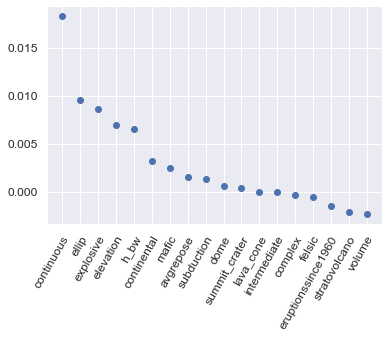

In [58]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Feature selection
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 10

# Create a list that holds results of feature selection
results = []

# Set up 5-fold cross validation
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
kf.get_n_splits(y)

# Loop through each fold
count = 0
for train_index, test_index in kf.split(y):
    count += 1
    X_train, X_test = Xt[train_index], Xt[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # This is the random forest model
    rsf = RandomSurvivalForest( n_estimators=1000,
                                min_samples_split=best['min_samples_split'],
                                min_samples_leaf=best['min_samples_leaf'],
                                max_features='sqrt',
                                n_jobs=-1,
                                random_state=seed+1)
    rsf.fit(X_train, y_train)

    # Use permutation importance to assess features
    perm = PermutationImportance(rsf, n_iter=15, random_state=seed+2)
    perm.fit(X_test, y_test)

    # Save results
    result = [ [x[0], x[1], x[2]] for x in zip(perm.feature_importances_, perm.feature_importances_std_, feature_names) ]
    result.sort(key=lambda x: x[0], reverse=True)
    results.append(result)

# Organize results
perm = [[],[],[]]
labels = []
avg = []
for feature in feature_names:
    perm[0].append( feature )
    perm[1].append( [] )
    perm[2].append( [] )
    for result in results:
        rT = list(map(list, zip(*result)))
        perm[1][-1].append( rT[0][ rT[2].index(feature) ] )
        perm[2][-1].append( rT[1][ rT[2].index(feature) ] )
perm[1] = [ np.mean(x) for x in perm[1] ]
for i in range(len(perm[1])):
    m = max( perm[1] )
    avg.append( m )
    labels.append( perm[0][ perm[1].index(m) ] )
    perm[0].pop( perm[1].index(m) )
    perm[1].pop( perm[1].index(m) )

# Plot results
plt.scatter( range( len( avg ) ), avg, zorder=10 )
plt.xticks( range(len( avg ) ), labels, rotation = 60, ha='right', rotation_mode="anchor" )
plt.axhline( 0, color='k', linestyle='--', lw=0.8, zorder=0 )
plt.show()

In [59]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Remove features that negatively affect the model and prepare data
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Remove features
remove = [ 'complex', 'felsic', 'eruptionssince1960', 'stratovolcano', 'volume' ]
DF.drop( columns=remove, inplace=True )

# Prepare data
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()
Xt = Xt.values

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Final optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 0

# Make a grid
min_samples_split = [5,10,15,20]
min_samples_leaf = [4,5,6]
n_estimators = [750,1000,1250]
param_grid = dict( min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators )

# Grid search
grid = GridSearchCV(estimator=RandomSurvivalForest( max_features='sqrt',
                                                    n_jobs=-1,
                                                    random_state=1 ),
                    param_grid=param_grid,
                    cv=KFold(random_state=seed, shuffle=True),
                    verbose=False)
grid_results = grid.fit( Xt, y )

# Assess results
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
best = grid_results.best_params_

print( 'Best: {0}, using {1}'.format(grid_results.best_score_, best) )

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index and brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator, once for each repeat of 5-fold cross validation
random_states = [ 20,21,22,23,24 ]

# Cross validation
results_c = [] #concordance index
results_b = [] #brier score
for seed in random_states:

    model = RandomSurvivalForest(n_estimators=1000,
                                 min_samples_split=best['min_samples_split'],
                                 min_samples_leaf=best['min_samples_leaf'],
                                 max_features='sqrt',
                                 n_jobs=-1,
                                 random_state=seed+1)
    
    kf = KFold(5, shuffle=True, random_state=seed)
    kf.get_n_splits(y)
    
    for train_index, test_index in kf.split(y):
        
        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        results_c.append(model.score(X_test,y_test))
        
        #filter test dataset so we only consider event times within the range given by the training datasets for brier score
        mask = (y_test.field(1) >= min(y_train.field(1))) & (y_test.field(1) <= max(y_train.field(1)))
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        survs = model.predict_survival_function(X_test)
        times = np.linspace( np.percentile([time[1] for time in y_test], 25), np.percentile([time[1] for time in y_test], 75), 10 )
        preds = np.asarray( [ [sf(t) for t in times] for sf in survs ] )
        score = integrated_brier_score(y_train, y_test, preds, times)
        
        results_b.append( score )

# Print results
print( 'Average concordance index ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results_c),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_c,ddof=1),4) ) )
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results_b),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_b,ddof=1),4) ) )

Best: 0.669652974373709, using {'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1250}
Average concordance index (5 repeats of 5-fold cross validation): 0.6669
Standard deviation: 0.0414
Average Brier score for (5 repeats of 5-fold cross validation): 0.1821
Standard deviation: 0.0127


Permutation explainer: 266it [42:57,  9.76s/it]                         


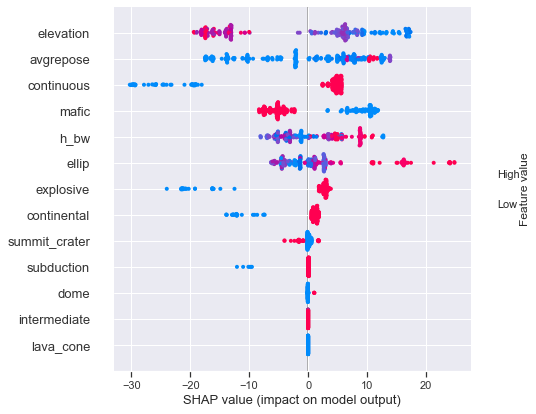

In [60]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#%% Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Set up model
rsf = RandomSurvivalForest(n_estimators=1000,
                                   min_samples_split=best['min_samples_split'],
                                   min_samples_leaf=best['min_samples_leaf'],
                                   max_features='sqrt',
                                   n_jobs=-1)
# Train model on entire dataset
rsf.fit(Xt, y)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#%% Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

explainer = shap.Explainer(rsf.predict, Xt, feature_names=feature_names)
shaps = explainer(Xt)
shap.summary_plot(shaps, Xt)

## 2.1.5. Gradient Boosted Models.
WRITE DESCRIPTION.

*2.1.5.1. Gradient Boosting.*<br>
WRITE DESCRIPTION.

*2.1.5.2. Component-wise Gradient Boosting.*<br>
WRITE DESCRIPTION.

### 2.1.5.1. Gradient Boosting.


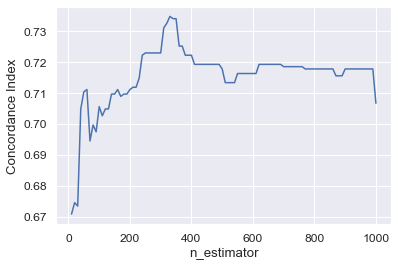

In [61]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare data
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

DF = df.copy()
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()
Xt = Xt.values

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Visualize n_estimators
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

seed = 1

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=seed)

scores_cph_tree = {}

model = GradientBoostingSurvivalAnalysis(
                                            learning_rate=0.1, max_depth=1, random_state=0
                                        )

for n_estimators in range(10, 1010, 10):
    model.set_params(n_estimators=n_estimators)
    model.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = model.score(X_test, y_test)

x_plot, y_plot = zip(*scores_cph_tree.items())
plt.plot(x_plot, y_plot)
plt.xlabel('n_estimator')
plt.ylabel('Concordance Index')
plt.show()

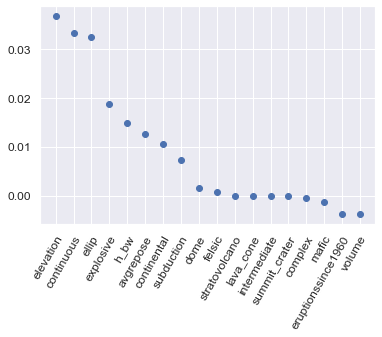

In [63]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#%% Feature selection
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 10

# Create a list that holds results of feature selection
results = []

# Set up 5-fold cross validation
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
kf.get_n_splits(y)

# Loop through each fold
count = 0
for train_index, test_index in kf.split(y):
    count += 1
    X_train, X_test = Xt[train_index], Xt[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # This is the gradient boosting model
    model = GradientBoostingSurvivalAnalysis(
                                                learning_rate=0.1, max_depth=1, random_state=1, n_estimators=800
                                            )
    model.fit(X_train, y_train)

    # Use permutation importance to assess features
    perm = PermutationImportance(model, n_iter=20, random_state=seed+2)
    perm.fit(X_test, y_test)

    # Save results
    result = [ [x[0], x[1], x[2]] for x in zip(perm.feature_importances_, perm.feature_importances_std_, feature_names) ]
    result.sort(key=lambda x: x[0], reverse=True)
    results.append(result)

# Organize results
perm = [[],[],[]]
labels = []
avg = []
for feature in feature_names:
    perm[0].append( feature )
    perm[1].append( [] )
    perm[2].append( [] )
    for result in results:
        rT = list(map(list, zip(*result)))
        perm[1][-1].append( rT[0][ rT[2].index(feature) ] )
        perm[2][-1].append( rT[1][ rT[2].index(feature) ] )
perm[1] = [ np.mean(x) for x in perm[1] ]
for i in range(len(perm[1])):
    m = max( perm[1] )
    avg.append( m )
    labels.append( perm[0][ perm[1].index(m) ] )
    perm[0].pop( perm[1].index(m) )
    perm[1].pop( perm[1].index(m) )

# Plot results
plt.scatter( range( len( avg ) ), avg, zorder=10 )
plt.xticks( range(len( avg ) ), labels, rotation = 60, ha='right', rotation_mode="anchor" )
plt.axhline( 0, color='k', linestyle='--', lw=0.8, zorder=0 )
plt.show()

In [64]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Remove features that negatively affect the model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

remove = [ 'complex', 'mafic', 'eruptionssince1960', 'volume' ]
DF.drop( columns=remove, inplace=True )
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()
Xt = Xt.values

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 1

# Make a small grid
learning_rate = np.logspace(-2,-1,5)
n_estimators  = np.arange(200,1400,300)
max_depth  = np.arange(1,3)
min_samples_split = np.arange(2,4)
min_samples_leaf  = np.arange(1,4)
dropout_rate = np.array([0,0.1,0.2])

param_grid = dict( learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, dropout_rate=dropout_rate )

# Grid search
grid = GridSearchCV(estimator=GradientBoostingSurvivalAnalysis( random_state=seed ),
                    param_grid=param_grid,
                    cv=KFold(random_state=seed+1, shuffle=True),
                    verbose=False)
grid_results = grid.fit( Xt, y )

# Assess results
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
best = grid_results.best_params_

print( 'Best: {0}, using {1}'.format(grid_results.best_score_, best) )

Best: 0.6848241616195743, using {'dropout_rate': 0.0, 'learning_rate': 0.03162277660168379, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 800}


In [66]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index and brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator, once for each repeat of 5-fold cross validation
random_states = [ 20,21,22,23,24 ]

# Cross validation
results_c = [] #concordance index
results_b = [] #brier score

for seed in random_states:
    
    model = GradientBoostingSurvivalAnalysis(
                                                learning_rate=best['learning_rate'], max_depth=best['max_depth'],
                                                n_estimators=best['n_estimators'], min_samples_split=best['min_samples_split'],
                                                min_samples_leaf=best['min_samples_leaf'], dropout_rate=best['dropout_rate'],
                                                random_state=seed
                                            )
    
    kf = KFold(5, shuffle=True, random_state=seed)
    kf.get_n_splits(y)
    
    for train_index, test_index in kf.split(y):
        
        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        results_c.append(model.score(X_test,y_test))
        
        #filter test dataset so we only consider event times within the range given by the training datasets for brier score
        mask = (y_test.field(1) >= min(y_train.field(1))) & (y_test.field(1) <= max(y_train.field(1)))
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        survs = model.predict_survival_function(X_test)
        times = np.linspace( np.percentile([time[1] for time in y_test], 25), np.percentile([time[1] for time in y_test], 75), 10 )
        preds = np.asarray( [ [sf(t) for t in times] for sf in survs ] )
        score = integrated_brier_score(y_train, y_test, preds, times)
        
        results_b.append( score )

# Print results
print( 'Average concordance index ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results_c),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_c,ddof=1),4) ) )
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results_b),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_b,ddof=1),4) ) )

Average concordance index (5 repeats of 5-fold cross validation): 0.69
Standard deviation: 0.0396
Average Brier score for (5 repeats of 5-fold cross validation): 0.1777
Standard deviation: 0.0227


Permutation explainer: 266it [00:21,  6.55it/s]                         


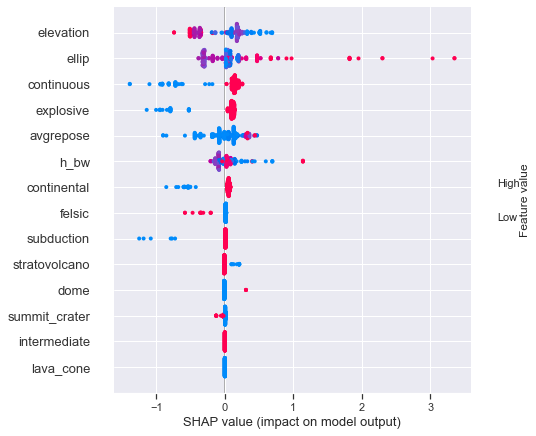

In [67]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
seed = 111

# Set up model
model = GradientBoostingSurvivalAnalysis(
                                            learning_rate=best['learning_rate'], max_depth=best['max_depth'],
                                            n_estimators=best['n_estimators'], min_samples_split=best['min_samples_split'],
                                            min_samples_leaf=best['min_samples_leaf'], dropout_rate=best['dropout_rate'],
                                            random_state=seed
                                        )
# Train model on entire dataset
model.fit(Xt, y)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

explainer = shap.Explainer(model.predict, Xt, feature_names=feature_names)
shaps = explainer(Xt)
shap.summary_plot(shaps, Xt)

### 2.1.5.2. Component-wise Gradient Boosting.

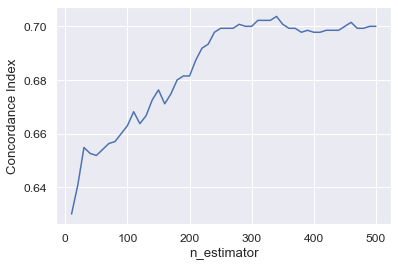

In [3]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis as cgb
from sksurv.metrics import integrated_brier_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare data
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

DF = df.copy()
d = DF.loc[:,['end', 'duration']]
d.end = d.end == 1
y = d.to_records(index=False)
Xt = DF.copy()
Xt.drop( columns=['duration','end'], inplace=True )
feature_names = Xt.columns.tolist()
Xt = Xt.values

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Visualize n_estimators
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
seed = 5

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=seed)

scores_cph_tree = {}

est_cph_tree = cgb(
                    learning_rate=1.0, random_state=0
                  )
for n_estimators in range(10, 510, 10):
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

x_plot, y_plot = zip(*scores_cph_tree.items())
plt.plot(x_plot, y_plot)
plt.xlabel('n_estimator')
plt.ylabel('Concordance Index')
plt.show()

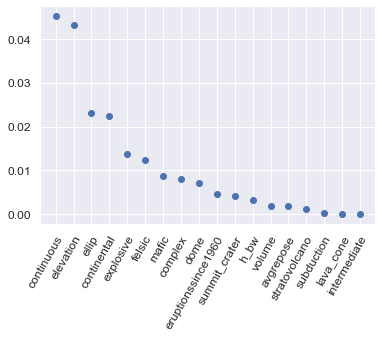

In [76]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Feature selection
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator
seed = 10

# Create a list that holds results of feature selection
results = []

# Set up 5-fold cross validation
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
kf.get_n_splits(y)

# Loop through each fold
for train_index, test_index in kf.split(y):
    X_train, X_test = Xt[train_index], Xt[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # This is the gradient boosting model
    model = cgb(
                learning_rate=0.1, random_state=1, n_estimators=3500
               )
    model.fit(X_train, y_train)

    # Use permutation importance to assess features
    perm = PermutationImportance(model, n_iter=20, random_state=seed+2)
    perm.fit(X_test, y_test)

    # Save results
    result = [ [x[0], x[1], x[2]] for x in zip(perm.feature_importances_, perm.feature_importances_std_, feature_names) ]
    result.sort(key=lambda x: x[0], reverse=True)
    results.append(result)

# Organize results
perm = [[],[],[]]
labels = []
avg = []
for feature in feature_names:
    perm[0].append( feature )
    perm[1].append( [] )
    perm[2].append( [] )
    for result in results:
        rT = list(map(list, zip(*result)))
        perm[1][-1].append( rT[0][ rT[2].index(feature) ] )
        perm[2][-1].append( rT[1][ rT[2].index(feature) ] )
perm[1] = [ np.mean(x) for x in perm[1] ]
for i in range(len(perm[1])):
    m = max( perm[1] )
    avg.append( m )
    labels.append( perm[0][ perm[1].index(m) ] )
    perm[0].pop( perm[1].index(m) )
    perm[1].pop( perm[1].index(m) )

# Plot results
plt.scatter( range( len( avg ) ), avg, zorder=10 )
plt.xticks( range(len( avg ) ), labels, rotation = 60, ha='right', rotation_mode="anchor" )
plt.axhline( 0, color='k', linestyle='--', lw=0.8, zorder=0 )
plt.show()

In [4]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Remove features that negatively affect the model - skipped for now, no negative features
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

#remove = [ '' ]
#DF.drop( columns=remove, inplace=True )
#Xt = DF.copy()
#Xt.drop( columns=['duration','end'], inplace=True )
#feature_names = Xt.columns.tolist()
#Xt = Xt.values

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import warnings

# Suppress runtime warnings for np.exp
warnings.filterwarnings('ignore')

# Initialize random number generator
seed = 1

# Make a small grid
learning_rate = np.logspace(-2,-1,5)
n_estimators  = np.arange(2000,4500,500)
dropout_rate = np.array([0,0.1,0.2])

param_grid = dict( learning_rate=learning_rate, n_estimators=n_estimators, dropout_rate=dropout_rate )

# Grid search
grid = GridSearchCV(estimator=cgb( random_state=seed ),
                    param_grid=param_grid,
                    cv=KFold(random_state=seed+1, shuffle=True),
                    verbose=False)
grid_results = grid.fit( Xt, y )

# Assess results
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
best = grid_results.best_params_

print( 'Best: {0}, using {1}'.format(grid_results.best_score_, best) )

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index and brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator, once for each repeat of 5-fold cross validation
random_states = [ 10,11,12,13,14 ]

# Cross validation
results_c = [] #concordance index
results_b = [] #brier score

for seed in random_states:

    model = cgb(
                    learning_rate=best['learning_rate'], n_estimators=best['n_estimators'],
                    dropout_rate=best['dropout_rate'], random_state=seed
               )

    kf = KFold(5, shuffle=True, random_state=seed)
    kf.get_n_splits(y)

    for train_index, test_index in kf.split(y):

        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        results_c.append(model.score(X_test,y_test))

        #filter test dataset so we only consider event times within the range given by the training datasets for brier score
        mask = (y_test.field(1) >= min(y_train.field(1))) & (y_test.field(1) <= max(y_train.field(1)))
        X_test = X_test[mask]
        y_test = y_test[mask]

        survs = model.predict_survival_function(X_test)
        times = np.linspace( np.percentile([time[1] for time in y_test], 25), np.percentile([time[1] for time in y_test], 75), 10 )
        preds = np.asarray( [ [sf(t) for t in times] for sf in survs ] )
        score = integrated_brier_score(y_train, y_test, preds, times)
        
        results_b.append( score )

# Print results
print( 'Average concordance index ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results_c),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_c,ddof=1),4) ) )
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results_b),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_b,ddof=1),4) ) )

Best: 0.6762147738100317, using {'dropout_rate': 0.0, 'learning_rate': 0.1, 'n_estimators': 4000}
Average concordance index (5 repeats of 5-fold cross validation): 0.6771
Standard deviation: 0.0335
Average Brier score for (5 repeats of 5-fold cross validation): 0.178
Standard deviation: 0.0169


Permutation explainer: 266it [00:10,  1.14s/it]                         


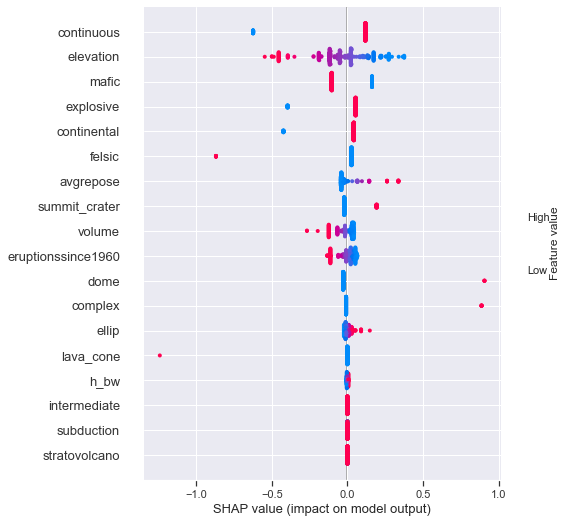

In [5]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Set up model
model = cgb(
              learning_rate=1.0, random_state=0, n_estimators=120
           )

# Train model on entire dataset
model.fit(Xt, y)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

explainer = shap.Explainer(model.predict, Xt, feature_names=feature_names)
shaps = explainer(Xt)
shap.summary_plot(shaps, Xt)

## 2.1.6. XGBoost Models.
WRITE DESCRIPTION.

*2.1.6.1. XGBoost: Accelerated Failure Time.*<br>
WRITE DESCRIPTION.

*2.1.6.2. XGBSE: DebiasedBCE.*<br>
WRITE DESCRIPTION.

*2.1.6.3. XGBSE: StackedWeibull.*<br>
WRITE DESCRIPTION.

*2.1.6.4. XGBSE: KaplanNeighbors.*<br>
WRITE DESCRIPTION.

*2.1.6.5. XGBSE: KaplanTree.*<br>
WRITE DESCRIPTION.

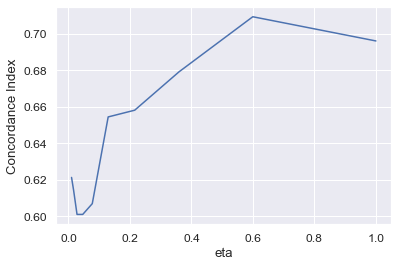

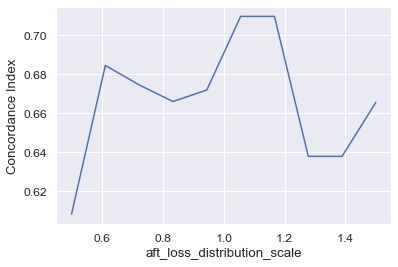

In [9]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import xgboost as xgb
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_data_to_xgb_format, convert_to_structured
from xgbse.metrics import concordance_index, approx_brier_score
from sklearn.model_selection import KFold, train_test_split

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare data
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

DF = df.copy()
X = DF.drop(['duration', 'end'], axis=1)
y = convert_to_structured(DF['duration'], DF['end'])

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Visualize model parameters
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

seed = 0

# make train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# convert to xgboost format
d_train = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
d_test = convert_data_to_xgb_format(X_test, y_test, 'survival:aft')

params = {'objective': 'survival:aft',
          'eval_metric': 'aft-nloglik',
          'aft_loss_distribution': 'normal',
          'aft_loss_distribution_scale': 1.20,
          'tree_method': 'hist',
          'learning_rate': 0.05, 'max_depth': 2}

scores_ci = {}
for eta in np.logspace(-2,0,10):
    params['learning_rate'] = eta
    model = xgb.train(params, d_train, num_boost_round=5,
                evals=[(d_train, 'train')], verbose_eval=False)
    pred = model.predict(d_test)
    scores_ci[eta] = concordance_index(y_test, -pred, risk_strategy='precomputed')

x_plot, y_plot = zip(*scores_ci.items())
plt.plot(x_plot, y_plot)
plt.xlabel('eta')
plt.ylabel('Concordance Index')
plt.show()

params['learning_rate'] = max(scores_ci, key=scores_ci. get)
scores_ci = {}
for aft_loss_distribution_scale in np.linspace(0.5,1.5,10):
    params['aft_loss_distribution_scale'] = aft_loss_distribution_scale
    model = xgb.train(params, d_train, num_boost_round=5,
                evals=[(d_train, 'train')], verbose_eval=False)
    pred = model.predict(d_test)
    scores_ci[aft_loss_distribution_scale] = concordance_index(y_test, -pred, risk_strategy='precomputed')

x_plot, y_plot = zip(*scores_ci.items())
plt.plot(x_plot, y_plot)
plt.xlabel('aft_loss_distribution_scale')
plt.ylabel('Concordance Index')
plt.show()


In [12]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator, once for each repeat of 5-fold cross validation
seed = 0

aft_loss_distribution = ['normal','logistic']
aft_loss_distribution_scale  = np.linspace(0.8,1.3,5)
learning_rate  = np.logspace(-0.5,0,5)
max_depth = np.arange(1,4)
n = len(aft_loss_distribution)*len(aft_loss_distribution_scale)*len(learning_rate)*len(max_depth)


kf = KFold(5, shuffle=True, random_state=seed)
kf.get_n_splits(y)
count = 1
score = 0


# convert to xgboost format
d_train = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
d_test = convert_data_to_xgb_format(X_test, y_test, 'survival:aft')

for ald in aft_loss_distribution:
    for alds in aft_loss_distribution_scale:
        for lr in learning_rate:
            for md in max_depth:
                params['aft_loss_distribution'] = ald
                params['aft_loss_distribution_scale'] = alds
                params['learning_rate'] = lr
                params['max_depth'] = md
                scores = []
                for train_index, test_index in kf.split(y):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    d_train = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
                    d_test = convert_data_to_xgb_format(X_test, y_test, 'survival:aft')
                    model = xgb.train(params, d_train, num_boost_round=5,
                                evals=[(d_train, 'train')], verbose_eval=False)
                    pred = model.predict(d_test)
                    s = concordance_index(y_test, -pred, risk_strategy='precomputed')
                    scores.append(s)
                if np.mean(scores) > score:
                    score = np.mean(scores)
                    best_ald = ald
                    best_alds = alds
                    best_lr = lr
                    best_md = md
                count += 1

print("Best: {}, using 'aft_loss_distribution': {}, 'aft_loss_distribution_scale': {}, 'learning_rate': {}, 'max_depth': {}".format(score, best_ald, best_alds, best_lr, best_md) )


Best: 0.7024387960274583, using 'aft_loss_distribution': normal, 'aft_loss_distribution_scale': 0.925, 'learning_rate': 1.0, 'max_depth': 3


In [14]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Cross validation, concordance index and brier score
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Initialize random number generator, once for each repeat of 5-fold cross validation
random_states = [ 20,21,22,23,24 ]

# Cross validation
results_c = [] #concordance index
results_b = [] #brier score

params['aft_loss_distribution'] = best_ald
params['aft_loss_distribution_scale'] = best_alds
params['learning_rate'] = best_lr
params['max_depth'] = best_md

for seed in random_states:

    kf = KFold(5, shuffle=True, random_state=seed)
    kf.get_n_splits(y)

    for train_index, test_index in kf.split(y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        d_train = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
        d_test = convert_data_to_xgb_format(X_test, y_test, 'survival:aft')

        model = xgb.train(params, d_train, num_boost_round=5,
                    evals=[(d_train, 'train')], verbose_eval=False)

        pred = model.predict(d_test)
        ci = concordance_index(y_test, -pred, risk_strategy='precomputed')
        results_c.append(ci)

# Print results
print( 'Average concordance index ({0} repeats of 5-fold cross validation): {1}'.format( len(random_states), round(np.mean(results_c),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_c,ddof=1),4) ) )

Average concordance index (5 repeats of 5-fold cross validation): 0.6914
Standard deviation: 0.0366


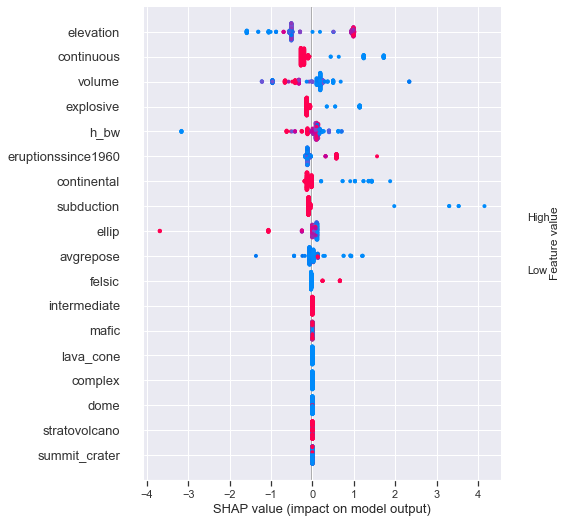

In [15]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Organize data
d = convert_data_to_xgb_format(X, y, 'survival:aft')

# Train model
model = xgb.train(params, d, num_boost_round=5,
                  evals=[(d, 'train')], verbose_eval=False)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Calculate shap values
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
explainer = shap.Explainer(model)
shaps = explainer(X)
shap.summary_plot(shaps, X)

## 2.1.7. Neural network (CoxTime) Model.
WRITE DESCRIPTION.

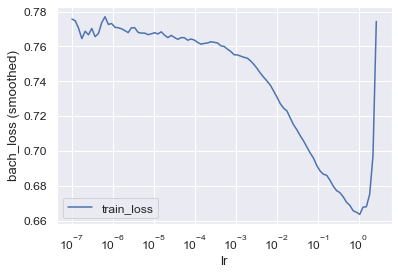

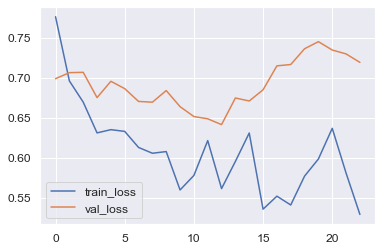

In [20]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Import libraries
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import KFold
import torch
import torchtuples as tt
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Prepare data
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Set random seeds
np.random.seed(1)
_ = torch.manual_seed(2)

# Prepare training and test datasets
DF = df.copy()
df_train = DF.copy()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

# Standardize
cols_standardize = [ 'elevation', 'volume', 'eruptionssince1960', 'avgrepose', 'h_bw', 'ellip' ]
cols_leave = ['explosive', 'continuous', 'stratovolcano', 'dome','complex','lava_cone','subduction', 'continental', 'mafic', 'intermediate', 'felsic', 'summit_crater' ]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['end'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)
val.shapes()
val.repeat(2).cat().shapes()

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Select learning rate
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# View partial log-liklihood
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

model.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = False
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())
_ = log.plot()


In [22]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#%% Optimization
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Initialize random number generator, once for each repeat of 5-fold cross validation
seed = 0

# define the grid search parameters
batch_size = [64, 128, 256]
n_epochs = [256, 512, 1024]
learning_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.1, 0.2, 0.3]
n = len(batch_size)*len(n_epochs)*len(learning_rate)*len(dropout_rate)

kf = KFold(5, shuffle=True, random_state=seed)
kf.get_n_splits(df)
count = 1
score = 0

for bs in batch_size:
    for ne in n_epochs:
        for lr in learning_rate:
            for dr in dropout_rate:
                scores = []
                for train_index, test_index in kf.split(df):
                    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
                    np.random.seed(1)
                    _ = torch.manual_seed(2)
                    df_val = df_train.sample(frac=0.2)
                    #df_train = df_train.drop(df_val.index) # we do not drop the validation data from the training set

                    x_train = x_mapper.fit_transform(df_train).astype('float32')
                    x_val = x_mapper.transform(df_val).astype('float32')
                    x_test = x_mapper.transform(df_test).astype('float32')
                    
                    labtrans = CoxTime.label_transform()
                    get_target = lambda df: (df['duration'].values, df['end'].values)
                    y_train = labtrans.fit_transform(*get_target(df_train))
                    y_val = labtrans.transform(*get_target(df_val))
                    durations_test, events_test = get_target(df_test)
                    val = tt.tuplefy(x_val, y_val)
                    
                    val.shapes()
                    val.repeat(2).cat().shapes()
                    
                    in_features = x_train.shape[1]
                    num_nodes = [32, 32]
                    batch_norm = True
                    dropout = dr
                    net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
                    
                    model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
                    batch_size = bs

                    model.optimizer.set_lr(lr)
                    epochs = ne

                    callbacks = [tt.callbacks.EarlyStopping()]
                    verbose = False
                    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                                    val_data=val.repeat(10).cat())
                    model.partial_log_likelihood(*val).mean()
                
                    _ = model.compute_baseline_hazards()
                    surv = model.predict_surv_df(x_test)

                    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
                    scores.append( ev.concordance_td() )

                if np.mean(scores) > score:
                    score = np.mean(scores)
                    best_bs = bs
                    best_ne = ne
                    best_lr = lr
                    best_dr = dr
                count += 1

print("Best: {}, using 'batch_size': {}, 'n_epochs': {}, 'learning_rate': {}, 'dropout_rate': {}".format(score, best_bs, best_ne, best_lr, best_dr) )


Best: 0.6917771846996257, using 'batch_size': 256, 'n_epochs': 256, 'learning_rate': 0.01, 'dropout_rate': 0.2


In [24]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# 5 repeats of 5-fold cross-validation
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

results_ci = [] #record concordance index
results_b = [] #record brier score

count = 1
for random_state in range(5):
    _ = torch.manual_seed(random_state+20)

    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)
    kf.get_n_splits(df)

    for train_index, test_index in kf.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]
        np.random.seed(random_state+1)
        _ = torch.manual_seed(random_state+2)
        df_val = df_train.sample(frac=0.2)
        #df_train = df_train.drop(df_val.index) # we do not drop the validation data from the training set

        x_train = x_mapper.fit_transform(df_train).astype('float32')
        x_val = x_mapper.transform(df_val).astype('float32')
        x_test = x_mapper.transform(df_test).astype('float32')

        labtrans = CoxTime.label_transform()
        get_target = lambda df: (df['duration'].values, df['end'].values)
        y_train = labtrans.fit_transform(*get_target(df_train))
        y_val = labtrans.transform(*get_target(df_val))
        durations_test, events_test = get_target(df_test)
        val = tt.tuplefy(x_val, y_val)

        val.shapes()
        val.repeat(2).cat().shapes()

        in_features = x_train.shape[1]
        num_nodes = [32, 32]
        batch_norm = True
        dropout = best_dr
        net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

        model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
        batch_size = best_bs

        model.optimizer.set_lr(best_lr)
        epochs = best_ne

        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = False
        log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=val.repeat(10).cat())
        model.partial_log_likelihood(*val).mean()

        _ = model.compute_baseline_hazards()
        surv = model.predict_surv_df(x_test)

        ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
        results_ci.append( ev.concordance_td() )

        times = np.linspace(np.percentile(df_train.duration,25), np.percentile(df_train.duration,75), 10)
        results_b.append( ev.integrated_brier_score(times) )
        count += 1

# Print results
print( 'Average concordance index ({0} repeats of 5-fold cross validation): {1}'.format( 5, round(np.mean(results_ci),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_ci,ddof=1),4) ) )
print( 'Average Brier score for ({0} repeats of 5-fold cross validation): {1}'.format( 5, round(np.mean(results_b),4) ) )
print( 'Standard deviation: {}'.format( round(np.std(results_b,ddof=1),4) ) )

Average concordance index (5 repeats of 5-fold cross validation): 0.6786
Standard deviation: 0.0348
Average Brier score for (5 repeats of 5-fold cross validation): 0.1755
Standard deviation: 0.0243


In [25]:
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# Train final model
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Set up model
np.random.seed(111)
_ = torch.manual_seed(222)
df_val = df.sample(frac=0.2)
#df_train = df_train.drop(df_val.index) # we do not drop the validation data from the training set
x_train = x_mapper.fit_transform(df).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['end'].values)
y_train = labtrans.fit_transform(*get_target(df))
y_val = labtrans.transform(*get_target(df_val))
val = tt.tuplefy(x_val, y_val)
val.shapes()
val.repeat(2).cat().shapes()
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = best_dr
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
batch_size = best_bs

model.optimizer.set_lr(best_lr)
epochs = best_ne

callbacks = [tt.callbacks.EarlyStopping()]
verbose = False
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())